# Large Long Graph Edge Effect Sizes Experiment

The MCI hypothesis and theory states that conditioning on the parents of X and Y will increase the effect size to detect a dependency. Say $X, Y \in V_G$ are a pair of nodes in the graph, G, and we obtain a minimal separating set, $Z_{min}$, from G for $X \perp Y$. To verify this, we will perform the following comparison given a graph, G and a pair of nodes X, Y that are dependent:

- compute the minimal separating set for X and Y using the oracle -> $Z_{min}$
- compute the CI test: $X \perp Y | Z_{min}$ and output its pvalue
- compute the CI test: $X \perp Y | Z_{min} \cup Pa(X) \cup Pa(Y)$ and output its pvalue
- repeat for all pairs of variables X and Y

Keep track of the following metrics:

- distance between X and Y

## Possible Complications

Theory states that the MCI test should be stronger. However, we could get issues due to purely random noise, so we might be interested in evaluating this experiment over different sample sizes. In addition, the choices of the CI test statistic may matter, so we should evaluate this also over different statistical tests, such as FisherZTest and PartialCorrelation and KernelCITest.

In [3]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from pathlib import Path
from pprint import pprint
import json
import collections
from itertools import combinations, chain

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from numpy.random import Generator, PCG64

import causal_networkx
from causal_networkx import DAG
from causal_networkx.ci import (
    FisherZCITest,
    GSquareCITest,
    PartialCorrelation,
    Oracle,
    ParentChildOracle,
    KernelCITest,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import read_dot, load_from_networkx
from causal_networkx.io import read_gml
from causal_networkx.metrics import (
    structure_hamming_dist,
    graph_to_pred_vector,
    confusion_matrix_networks,
)
from causal_networkx.algorithms import (
    d_separated,
    is_separating_set_minimal,
    compute_minimal_separating_set,
    moralize_graph,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
np.random.seed(12345)

# Set up to load the data

The data should have been previously generated via the manm_cs package for additive noise models. We will load the data in with specific parameters.

In [10]:
data_dir = Path("/Volumes/Extreme Pro/structure_learning_manm_sim/long_chains/")

In [11]:
n_datasets = len(list(data_dir.glob("*.csv")))
print(n_datasets)

10


# Define Functions for Experimental Analysis

In [12]:
def compute_dep_vars_without_adj(G):
    for node1, node2 in combinations(G.nodes, 2):
        # check that the two nodes are dependent, but not adjacent
        if not d_separated(G, node1, node2) and not G.has_adjacency(node1, node2):
            yield node1, node2


def compute_dep_vars(G):
    for node1, node2 in combinations(G.nodes, 2):
        # check that the two nodes are dependent, but not adjacent
        if not d_separated(G, node1, node2):
            yield node1, node2

In [13]:
def _compute_ci_exp(true_graph, ci_estimator, df, idx):
    result_dict = collections.defaultdict(list)

    # compute all dependent variables
    dep_var_tuples = compute_dep_vars_without_adj(true_graph)

    copy_graph = true_graph.copy()

    n_samples = df.shape[0]
    # generate a random set of variables
    for i in range(10):
        node_name = f"noise-{i}"
        true_graph.add_node(node_name)
        df[node_name] = np.random.normal(size=(n_samples,))

    # for each pair of dependent variables, we will compute the minimal separating set
    for X, Y in dep_var_tuples:
        # compute the min sep set
        Z_min = compute_minimal_separating_set(true_graph, X, Y)

        # double check that the separating set is minimal given the moralization
        assert is_separating_set_minimal(true_graph, X, Y, Z_min)

        # now add the parent set
        X_parents = set(true_graph.parents(X))
        Y_parents = set(true_graph.parents(Y))

        Z_mci = Z_min.union(X_parents).union(Y_parents)
        if Z_mci == Z_min:
            continue

        # now add the parent set
        X_children = set(true_graph.children(X))
        Y_children = set(true_graph.children(Y))
        Z_child = Z_min.union(X_children).union(Y_children)

        # artificially add parents for to test increasing the conditioning set size
        n_parents = len(Z_mci) - len(Z_min)
        Z_noise = Z_min.union({f"noise-{i}" for i in range(n_parents)})
        assert len(Z_noise) == len(Z_mci)

        # now lets compute the pvalue
        stat, pvalue = ci_estimator.test(df, X, Y, Z_min)
        mci_stat, mci_pvalue = ci_estimator.test(df, X, Y, Z_mci)
        child_stat, child_pvalue = ci_estimator.test(df, X, Y, Z_child)
        noise_stat, noise_pvalue = ci_estimator.test(df, X, Y, Z_noise)

        # compute the shortest path between X and Y and its length
        path_len = nx.shortest_path_length(true_graph.dag.to_undirected(), X, Y)

        result_dict["x"].append(X)
        result_dict["y"].append(Y)
        result_dict["pvalue_min"].append(pvalue)
        result_dict["pvalue_mci"].append(mci_pvalue)
        result_dict["stat_min"].append(stat)
        result_dict["stat_mci"].append(mci_stat)

        result_dict["pvalue_noise"].append(noise_pvalue)
        result_dict["stat_noise"].append(noise_stat)
        result_dict["pvalue_child"].append(child_pvalue)
        result_dict["stat_child"].append(child_stat)

        result_dict["mci_cond_ind"].append(d_separated(true_graph, X, Y, Z_mci))
        result_dict["path_len"].append(path_len)
        result_dict["z_size"].append(len(Z_min))
        result_dict["mci_size"].append(len(Z_mci.difference(Z_min)))
        result_dict["mci_addition"].append(Z_mci.difference(Z_min))
        result_dict["child_addition"].append(len(Z_child.difference(Z_min)))
        result_dict["idx"].append(idx)

        true_graph = copy_graph.copy()
    return result_dict

In [14]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)))


print(list(powerset([1, 2, 3])))

[(), (1,), (2,), (3,), (1, 2), (1, 3), (2, 3)]


In [15]:
def _add_set_keeping_cd(graph, X, Y, Z, ref_Z, add_set):
    for pa in add_set:
        if pa not in ref_Z and not d_separated(graph, X, Y, Z.copy().union((pa,))):
            Z.add(pa)
    return Z

In [22]:
def _compute_cd_exp(true_graph, ci_estimator, df, idx):
    result_dict = collections.defaultdict(list)

    # compute all dependent variables
    dep_var_tuples = compute_dep_vars_without_adj(true_graph)

    copy_graph = true_graph.copy()

    n_samples = df.shape[0]
    # generate a random set of variables
    for i in range(10):
        node_name = f"noise-{i}"
        true_graph.add_node(node_name)
        df[node_name] = np.random.normal(size=(n_samples,))

    # for each pair of dependent variables, we will compute the minimal separating set
    for X, Y in dep_var_tuples:
        # compute the min sep set
        Z_min = compute_minimal_separating_set(true_graph, X, Y)

        add_X_parents = True
        add_Y_parents = True
        if X in true_graph.descendants(Y):
            add_X_parents = False
        if Y in true_graph.descendants(X):
            add_Y_parents = False

        # now compute the true parents
        X_parents = set(true_graph.parents(X))
        Y_parents = set(true_graph.parents(Y))

        # now add the children set
        X_children = set(true_graph.children(X))
        Y_children = set(true_graph.children(Y))

        # now let us loop over all possible subsets of Z_min
        for Z_sub in powerset(Z_min):
            Z_sub = set(Z_sub)
            Z_mci = Z_sub.copy()

            # determine if X -> ... -> Y or Y -> ... -> X
            if nx.has_path(true_graph.dag, X, Y):
                # X is an ancestral cause of Y
                for pa in Y_parents:
                    if pa not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((pa,))
                    ):
                        Z_mci.add(pa)
                for ch in X_children:
                    if ch not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((ch,))
                    ):
                        Z_mci.add(ch)
            elif nx.has_path(true_graph.dag, Y, X):
                # next check if we can add MCI without inducing d-separation
                for pa in X_parents:
                    if pa not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((pa,))
                    ):
                        Z_mci.add(pa)
                for ch in Y_children:
                    if ch not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((ch,))
                    ):
                        Z_mci.add(ch)
            # if add_X_parents:
            #     Z_mci = _add_set_keeping_cd(true_graph, X, Y, Z_mci, Z_min, X_parents)
            # if add_Y_parents:
            #     Z_mci = _add_set_keeping_cd(true_graph, X, Y, Z_mci, Z_min, Y_parents)

            if Z_mci == Z_sub:
                continue

            assert not d_separated(true_graph, X, Y, Z_mci)
            assert not d_separated(true_graph, X, Y, Z_sub)

            # artificially add parents for to test increasing the conditioning set size
            n_parents = len(Z_mci) - len(Z_sub)
            Z_noise = Z_sub.union({f"noise-{i}" for i in range(n_parents)})
            assert len(Z_noise) == len(Z_mci)

            # now add children
            # Z_child = Z_sub.copy()
            # Z_child = _add_set_keeping_cd(true_graph, X, Y, Z_child, Z_min, X_children)
            # Z_child = _add_set_keeping_cd(true_graph, X, Y, Z_child, Z_min, Y_children)

            # now lets compute the pvalue
            stat, pvalue = ci_estimator.test(df, X, Y, Z_sub)
            mci_stat, mci_pvalue = ci_estimator.test(df, X, Y, Z_mci)

            # child_stat, child_pvalue = ci_estimator.test(df, X, Y, Z_child)
            noise_stat, noise_pvalue = ci_estimator.test(df, X, Y, Z_noise)

            # compute the shortest path between X and Y and its length
            path_len = nx.shortest_path_length(true_graph.dag.to_undirected(), X, Y)

            if np.isnan(pvalue):
                raise RuntimeError(f"WTF {X}-{Y} with {Z_sub}, {Z_mci}")

            result_dict["x"].append(X)
            result_dict["y"].append(Y)
            result_dict["pvalue_min"].append(pvalue)
            result_dict["pvalue_mci"].append(mci_pvalue)
            result_dict["stat_min"].append(stat)
            result_dict["stat_mci"].append(mci_stat)

            result_dict["pvalue_noise"].append(noise_pvalue)
            result_dict["stat_noise"].append(noise_stat)
            # result_dict["pvalue_child"].append(child_pvalue)
            # result_dict["stat_child"].append(child_stat)

            # result_dict["child_cond_ind"].append(d_separated(true_graph, X, Y, Z_child))
            result_dict["mci_cond_ind"].append(d_separated(true_graph, X, Y, Z_mci))
            result_dict["path_len"].append(path_len)
            result_dict["z_size"].append(len(Z_min))
            result_dict["mci_size"].append(len(Z_mci.difference(Z_min)))
            result_dict["mci_addition"].append(Z_mci.difference(Z_min))
            # result_dict["child_addition"].append(len(Z_child.difference(Z_min)))
            result_dict["idx"].append(idx)

            true_graph = copy_graph.copy()
    return result_dict

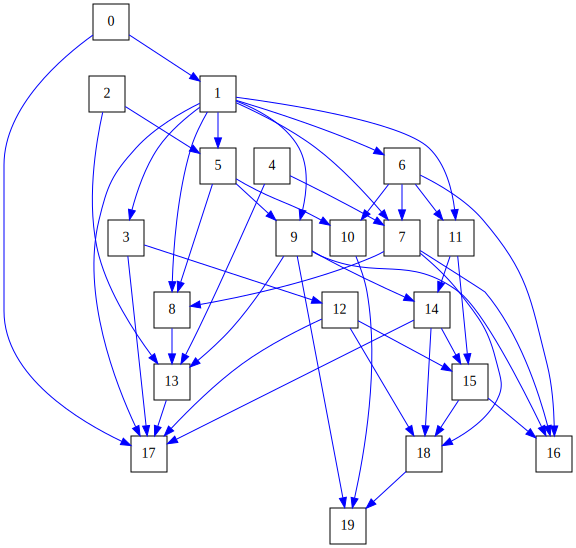

In [17]:
z = [5 for i in range(20)]
G = nx.expected_degree_graph(z)
# Convert generated graph to DAG
dag = nx.DiGraph()
dag.add_nodes_from(G)
dag.add_edges_from([(u, v, {}) for (u, v) in G.edges() if u < v])
assert nx.is_directed_acyclic_graph(dag)

G = DAG(dag)
G.draw()

In [21]:
print(nx.has_path(G.dag, 18, 19))
print(nx.has_path(G.dag, 19, 18))

True
False


# Analyze the Data

In [18]:
ci_est = "parcorr"
ci_estimator = PartialCorrelation(method="pingouin")

ci_est = "fisherz"
ci_estimator = FisherZCITest()

ci_est = "kernelci"
ci_estimator = KernelCITest()

# Analyze effects of increasing conditioning set size

In [506]:
print(true_graph)
print(true_graph.edges(data=True))

DAG with 26 nodes, 37 edges
[('0', '2', {}), ('0', '16', {}), ('0', '24', {}), ('1', '5', {}), ('1', '10', {}), ('2', '5', {}), ('2', '14', {}), ('2', '16', {}), ('3', '11', {}), ('3', '19', {}), ('3', '20', {}), ('4', '9', {}), ('4', '19', {}), ('5', '14', {}), ('5', '17', {}), ('6', '8', {}), ('6', '17', {}), ('6', '20', {}), ('6', '22', {}), ('7', '8', {}), ('7', '9', {}), ('7', '17', {}), ('8', '12', {}), ('8', '14', {}), ('8', '19', {}), ('8', '22', {}), ('9', '22', {}), ('10', '16', {}), ('11', '13', {}), ('11', '19', {}), ('11', '24', {}), ('13', '21', {}), ('14', '20', {}), ('15', '17', {}), ('16', '24', {}), ('17', '19', {}), ('20', '21', {})]


In [358]:
jdx = 0
# compute analysis of CD experiments
for idx in range(n_datasets):
    data_fname = data_dir / f"graph_{idx}.csv"
    graph_fname = data_dir / f"graph_{idx}.gml"
    meta_fname = data_dir / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)

    result_dict = collections.defaultdict(list)

    # compute all dependent variables
    dep_var_tuples = compute_dep_vars_without_adj(true_graph)

    copy_graph = true_graph.copy()

    # for each pair of dependent variables, we will compute the minimal separating set
    for X, Y in dep_var_tuples:
        # compute the min sep set
        Z_min = compute_minimal_separating_set(true_graph, X, Y)

        rest_nodes = set(true_graph.nodes)
        rest_nodes = rest_nodes - Z_min
        rest_nodes.remove(X)
        rest_nodes.remove(Y)

        for nodes in powerset(rest_nodes):
            Z_sub = Z_min.copy()
            Z_sub = Z_sub.union(set(nodes))

            # assert d_separated(true_graph, X, Y, Z_sub)

            # now lets compute the pvalue
            stat, pvalue = ci_estimator.test(df, X, Y, Z_sub)
            mci_stat, mci_pvalue = ci_estimator.test(df, X, Y, Z_mci)
            # compute the shortest path between X and Y and its length
            path_len = nx.shortest_path_length(true_graph.dag.to_undirected(), X, Y)

            if np.isnan(pvalue):
                raise RuntimeError(f"WTF {X}-{Y} with {Z_sub}, {Z_mci}")

            result_dict["x"].append(X)
            result_dict["y"].append(Y)
            result_dict["cond_ind"].append(d_separated(true_graph, X, Y, Z_sub))
            result_dict["pvalue_min"].append(pvalue)
            # result_dict["pvalue_mci"].append(mci_pvalue)
            result_dict["stat_min"].append(stat)
            # result_dict["stat_mci"].append(mci_stat)
            result_dict["path_len"].append(path_len)
            result_dict["z_size"].append(len(Z_sub))
            # result_dict["mci_size"].append(len(Z_mci.difference(Z_sub)))
            # result_dict["mci_addition"].append(Z_mci.difference(Z_sub))
            result_dict["idx"].append(idx)

            true_graph = copy_graph.copy()

            jdx += 1
            if jdx > 10000:
                break
    break

In [359]:
result_df = pd.DataFrame.from_dict(result_dict)

print(result_df.shape)

(10088, 8)


(3119, 8)


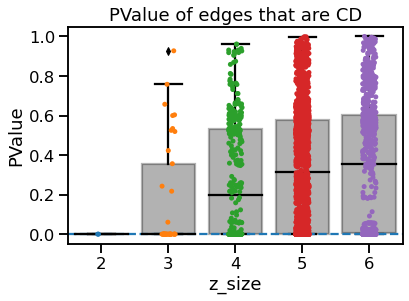

In [366]:
plot_df = result_df.copy()
plot_df = plot_df[plot_df["cond_ind"] == False]
print(plot_df.shape)
fig, ax = plt.subplots()
sns.stripplot(x="z_size", y="pvalue_min", data=plot_df, ax=ax)
sns.boxplot(
    x="z_size",
    y="pvalue_min",
    data=plot_df,
    ax=ax,
    color="black",
    boxprops=dict(alpha=0.3),
)
ax.set(
    ylabel="PValue",
    title="PValue of edges that are CD",
)
ax.axhline([0], ls="--")

(6969, 8)


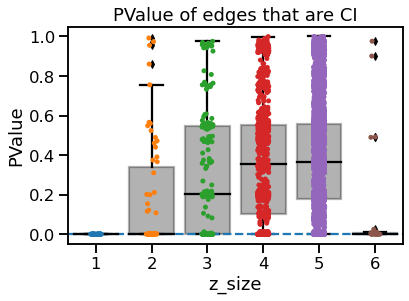

In [367]:
plot_df = result_df.copy()
plot_df = plot_df[plot_df["cond_ind"] == True]
print(plot_df.shape)
fig, ax = plt.subplots()
sns.stripplot(x="z_size", y="pvalue_min", data=plot_df, ax=ax)
sns.boxplot(
    x="z_size",
    y="pvalue_min",
    data=plot_df,
    ax=ax,
    color="black",
    boxprops=dict(alpha=0.3),
)
ax.set(
    ylabel="PValue",
    title="PValue of edges that are CI",
)
ax.axhline([0], ls="--")

## Analyze effects of MCI on testing conditional independence

In [404]:
# compute analysis of CI experiments
for idx in range(n_datasets):
    data_fname = data_dir / f"graph_{idx}.csv"
    graph_fname = data_dir / f"graph_{idx}.gml"
    meta_fname = data_dir / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)
    
        # break
    result_dict = _compute_ci_exp(true_graph, ci_estimator, df, idx)
    # result_df = pd.DataFrame.from_dict(result_dict)
    break

ValueError: Length of values (5000) does not match length of index (2000)

## Analyze effects of MCI on testing conditional dependence

In [369]:
jdx = 0
# compute analysis of CD experiments
for idx in range(n_datasets):
    data_fname = data_dir / f"graph_{idx}.csv"
    graph_fname = data_dir / f"graph_{idx}.gml"
    meta_fname = data_dir / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)

    result_dict = collections.defaultdict(list)

    # compute all dependent variables
    dep_var_tuples = compute_dep_vars_without_adj(true_graph)

    copy_graph = true_graph.copy()

    # for each pair of dependent variables, we will compute the minimal separating set
    for X, Y in dep_var_tuples:
        # compute over all possible set of nodes
        rest_nodes = set(true_graph.nodes)
        rest_nodes.remove(X)
        rest_nodes.remove(Y)

        # get parent and children set
        X_parents = true_graph.parents(X)
        Y_parents = true_graph.parents(Y)
        X_children = true_graph.children(X)
        Y_children = true_graph.children(Y)
        
        for Z_sub in powerset(rest_nodes):
            Z_sub = set(Z_sub)
            # only analyze conditionally dependent statements
            if d_separated(true_graph, X, Y, Z_sub):
                continue

            Z_mci = Z_sub.copy()
            
            # determine if X -> ... -> Y or Y -> ... -> X
            if nx.has_path(true_graph.dag, X, Y):
                # X is an ancestral cause of Y
                for pa in Y_parents:
                    if pa not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((pa,))
                    ):
                        Z_mci.add(pa)
                for ch in X_children:
                    if ch not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((ch,))
                    ):
                        Z_mci.add(ch)
            else:
                # next check if we can add MCI without inducing d-separation
                for pa in X_parents:
                    if pa not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((pa,))
                    ):
                        Z_mci.add(pa)
                for ch in Y_children:
                    if ch not in Z_min and not d_separated(
                        true_graph, X, Y, Z_mci.copy().union((ch,))
                    ):
                        Z_mci.add(ch)
            if Z_mci == Z_sub:
                continue
            assert not d_separated(true_graph, X, Y, Z_mci)

            # now lets compute the pvalue
            stat, pvalue = ci_estimator.test(df, X, Y, Z_sub)
            mci_stat, mci_pvalue = ci_estimator.test(df, X, Y, Z_mci)
            # compute the shortest path between X and Y and its length
            path_len = nx.shortest_path_length(true_graph.dag.to_undirected(), X, Y)

            if np.isnan(pvalue):
                raise RuntimeError(f"WTF {X}-{Y} with {Z_sub}, {Z_mci}")

            result_dict["x"].append(X)
            result_dict["y"].append(Y)
            result_dict["cond_ind"].append(d_separated(true_graph, X, Y, Z_sub))
            result_dict["pvalue_min"].append(pvalue)
            result_dict["pvalue_mci"].append(mci_pvalue)
            result_dict["stat_min"].append(stat)
            result_dict["stat_mci"].append(mci_stat)
            result_dict["path_len"].append(path_len)
            result_dict["z_size"].append(len(Z_sub))
            result_dict["mci_size"].append(len(Z_mci.difference(Z_sub)))
            result_dict["mci_addition"].append(Z_mci.difference(Z_sub))
            result_dict["idx"].append(idx)

            true_graph = copy_graph.copy()

            jdx += 1
            if jdx > 10000:
                break
    break

In [371]:
result_df = pd.DataFrame.from_dict(result_dict)
display(result_df.head())
print(result_df.shape)
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

,x,y,cond_ind,pvalue_min,pvalue_mci,stat_min,stat_mci,path_len,z_size,mci_size,mci_addition,idx
0,0,5,False,0.000000,0.700551,17.783688,0.384577,2,0,2,"{11, 16}",0
1,0,5,False,0.330398,0.693684,0.973313,0.393861,2,1,2,"{11, 16}",0
2,0,5,False,0.762769,0.537128,0.301846,0.617161,2,1,2,"{11, 16}",0
3,0,5,False,0.000000,0.967108,16.309896,0.041235,2,1,2,"{11, 16}",0
4,0,5,False,0.109903,0.112466,1.598631,1.587204,2,1,2,"{11, 16}",0


(10088, 12)


(10088, 13)


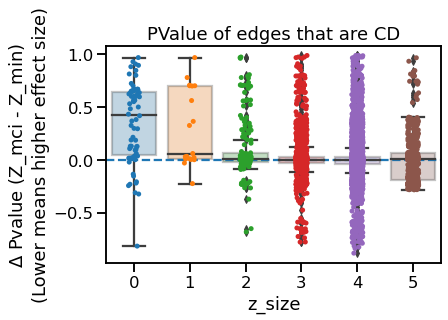

In [376]:
plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

fig, ax = plt.subplots()
sns.stripplot(
    x="z_size",
    y="pvalue_diff",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    x="z_size",
    y="pvalue_diff",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.3),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Lower means higher effect size)",
    title="PValue of edges that are CD",
)
ax.axhline([0], ls="--")

In [317]:
# compute analysis of CD experiments
for idx in range(n_datasets):
    data_fname = data_dir / f"graph_{idx}.csv"
    graph_fname = data_dir / f"graph_{idx}.gml"
    meta_fname = data_dir / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)

    result_dict = _compute_cd_exp(true_graph, ci_estimator, df, idx)

    result_df = pd.DataFrame.from_dict(result_dict)
    break

In [318]:
print(Z_sub)

{'13'}


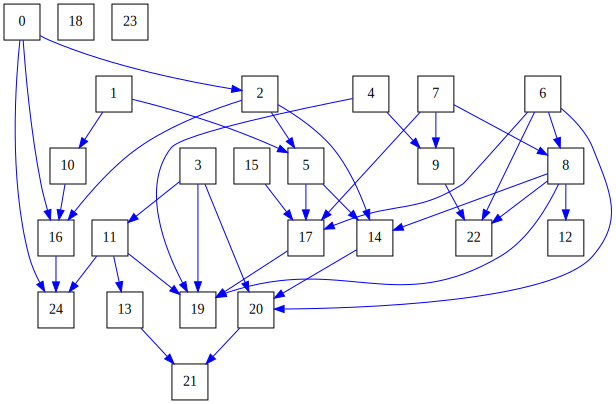

In [389]:
true_graph.draw()

In [390]:
# list all conditional independences
# compute all dependent variables
G = true_graph.copy()
dep_var_tuples = compute_dep_vars_without_adj(G)

# for each pair of dependent variables, we will compute the minimal separating set
for X, Y in dep_var_tuples:
    # compute the min sep set
    Z_min = compute_minimal_separating_set(G, X, Y)

    print(X, Y, Z_min)

0 5 {'2'}
0 14 {'2'}
0 17 {'5'}
0 19 {'17', '8'}
0 20 {'6', '14'}
0 21 {'20', '13'}
1 14 {'5', '2'}
1 16 {'10'}
1 17 {'5'}
1 19 {'17', '8'}
1 20 {'6', '14'}
1 21 {'20', '13'}
1 24 {'0', '16'}
2 17 {'5'}
2 19 {'17', '8'}
2 20 {'6', '14'}
2 21 {'20', '13'}
2 24 {'0', '16'}
3 13 {'11'}
3 21 {'20', '13'}
3 24 {'11'}
4 22 {'6', '8', '9'}
5 10 {'1'}
5 16 {'1', '2'}
5 19 {'17', '8'}
5 20 {'6', '14'}
5 21 {'20', '13'}
5 24 {'1', '2'}
6 12 {'8'}
6 14 {'8'}
6 19 {'17', '8'}
6 21 {'20', '13'}
7 12 {'8'}
7 14 {'8'}
7 19 {'17', '8'}
7 20 {'6', '14'}
7 21 {'20', '13'}
7 22 {'6', '8', '9'}
8 9 {'7'}
8 17 {'7', '6'}
8 20 {'6', '14'}
8 21 {'20', '13'}
9 12 {'7'}
9 14 {'7'}
9 17 {'7'}
9 19 {'7', '4'}
9 20 {'7'}
9 21 {'7'}
10 14 {'1'}
10 17 {'1'}
10 19 {'1'}
10 20 {'1'}
10 21 {'1'}
10 24 {'0', '16'}
11 20 {'3'}
11 21 {'3', '13'}
12 14 {'8'}
12 17 {'8'}
12 19 {'8'}
12 20 {'8'}
12 21 {'8'}
12 22 {'8'}
13 19 {'11'}
13 20 {'11'}
13 24 {'11'}
14 16 {'5', '2'}
14 17 {'5', '8'}
14 19 {'5', '8'}
14 21 {'20', '13

## Postprocess the data and experimental result

In [321]:
# result_df = pd.DataFrame.from_dict(result_dict)
display(result_df.head())
print(result_df.shape)
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

,x,y,pvalue_min,pvalue_mci,stat_min,stat_mci,path_len,mci_size,mci_addition,idx,pvalue_diff
0,0,5,0.000000e+00,0.000000e+00,18.776347,10.992204,2,1,{1},0,0.000000e+00
1,0,14,2.564514e-01,2.220446e-16,1.134819,8.201782,2,2,"{5, 8}",0,-2.564514e-01
2,0,17,0.000000e+00,6.537168e-09,10.959833,5.802402,3,3,"{7, 6, 15}",0,6.537168e-09
3,0,19,4.440892e-16,9.879718e-01,8.138063,0.015076,3,3,"{4, 11, 3}",0,9.879718e-01
4,0,19,2.857714e-13,2.988213e-02,7.300972,2.171649,3,3,"{4, 11, 3}",0,2.988213e-02


(203, 11)


In [ ]:
# save to disc
fname = f'~/Downloads/{ci_est}_cd_experiment.csv'
result_df.to_csv(fname)

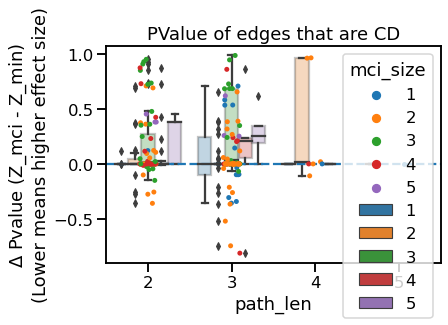

In [324]:
fig, ax = plt.subplots()
sns.stripplot(x="path_len", y="pvalue_diff", hue="mci_size", data=result_df, ax=ax)
sns.boxplot(
    x="path_len",
    y="pvalue_diff",
    hue="mci_size",
    data=result_df,
    ax=ax,
    boxprops=dict(alpha=0.3),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Lower means higher effect size)",
    title="PValue of edges that are CD",
)
ax.axhline([0], ls="--")

# Simulate Random Graphs Starting From Same Graph

In [23]:
from manm_cs.graph import GraphBuilder


fname = "/Users/adam2392/Downloads/test.gml"
# fname = "/Users/adam2392/Downloads/degree_graph.gml"

In [24]:
ci_est = "parcorr"
ci_estimator = PartialCorrelation(method="pingouin")

ci_est = "fisherz"
ci_estimator = FisherZCITest()

# ci_est = "kernelci"
# ci_estimator = KernelCITest()

In [47]:
def lin_func(x):
    return x


seed = 12345
np.random.seed(seed)
rng = Generator(PCG64(seed))

n_samples = 5000
discrete_node_ratio = 0.0
# discrete_signal_to_noise_ratio=0.9
with_conditional_gaussian = True
beta_lower_limit = 0.1
beta_upper_limit = 2.0

n_jobs = 1

# read in graph
graph = nx.read_gml(fname)

# or generate from scratch
z = [rng.normal(5, 1, size=(1,)) for i in range(20)]
G = nx.expected_degree_graph(z)
# Convert generated graph to DAG
dag = nx.DiGraph()
dag.add_nodes_from(G)
dag.add_edges_from([(u, v, {}) for (u, v) in G.edges() if u < v])
assert nx.is_directed_acyclic_graph(dag)
graph = dag
# G = DAG(dag)
# graph = G.copy()

mapping = {node: f"{node}" for node in graph.nodes}
nx.relabel_nodes(graph, mapping, copy=False)

result_df = pd.DataFrame()
idx = 0

for jdx in range(20):
    for weight_function in [
        [(1.0, lin_func)],
        # [(0.5, lin_func), (0.3, lin_func), (0.2, lin_func)],
        # [(0.1, lin_func), (0.3, lin_func), (0.4, lin_func), (0.2, lin_func)],
    ]:
        for continuous_noise_std in [1.0]:  # np.linspace(0.1, 1.0, 10):
            graph_builder = (
                GraphBuilder()
                # .with_graph_structure_file(fname)
                .with_networkx_DiGraph(graph)
                .with_discrete_node_ratio(discrete_node_ratio)
                # .with_discrete_signal_to_noise_ratio(discrete_signal_to_noise_ratio)
                # .with_min_discrete_value_classes(min_discrete_value_classes)
                # .with_max_discrete_value_classes(max_discrete_value_classes)
                .with_continuous_noise_std(continuous_noise_std)
                .with_functions(weight_function)
                .with_conditional_gaussian(with_conditional_gaussian)
                .with_betas(beta_lower_limit, beta_upper_limit)
            )

            manm_graph = graph_builder.build(seed=seed)

            # first sample the data
            df = manm_graph.sample(num_observations=n_samples, num_processes=n_jobs)

            # next let's convert the graph to networkx, so we can convert to DAG
            nx_graph = manm_graph.to_networkx_graph()
            causal_dag = DAG(nx_graph)

            if isinstance(df, list):
                df = pd.concat(df)

            # compute experiment over CI and CD
            # result_dict = _compute_ci_exp(causal_dag, ci_estimator, df, idx)
            result_dict = _compute_cd_exp(causal_dag, ci_estimator, df, idx)
            # break
            _result_df = pd.DataFrame.from_dict(result_dict)
            result_df = pd.concat((result_df, _result_df), axis=0)
            idx += 1
    #     break
    # break

In [48]:
print(result_df.shape)
display(result_df)

(48680, 14)


,x,y,pvalue_min,pvalue_mci,stat_min,stat_mci,pvalue_noise,stat_noise,mci_cond_ind,path_len,z_size,mci_size,mci_addition,idx
0,0,15,0.000000e+00,2.220446e-16,52.258107,8.190552,0.000000e+00,52.229420,False,2,4,3,"{3, 8, 7}",0
1,0,15,0.000000e+00,0.000000e+00,60.597772,8.773283,0.000000e+00,60.578922,False,2,4,3,"{3, 8, 7}",0
2,0,15,0.000000e+00,1.370168e-02,17.950867,2.464991,0.000000e+00,17.947820,False,2,4,3,"{3, 8, 7}",0
3,0,15,0.000000e+00,2.482459e-13,29.333273,7.319849,0.000000e+00,29.320384,False,2,4,3,"{3, 8, 7}",0
4,0,15,2.725759e-01,0.000000e+00,1.097150,8.885607,2.761857e-01,1.088928,False,2,4,3,"{3, 8, 7}",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,3,17,0.000000e+00,0.000000e+00,12.735196,76.731793,0.000000e+00,12.747550,False,3,3,3,"{8, 19, 16}",19
2430,3,17,0.000000e+00,0.000000e+00,11.239336,23.997881,0.000000e+00,11.225846,False,3,3,3,"{8, 19, 16}",19
2431,3,17,0.000000e+00,0.000000e+00,8.629055,76.323534,0.000000e+00,8.641177,False,3,3,3,"{8, 19, 16}",19
2432,3,17,4.440892e-16,0.000000e+00,8.127293,23.861556,4.440892e-16,8.123356,False,3,3,3,"{8, 19, 16}",19


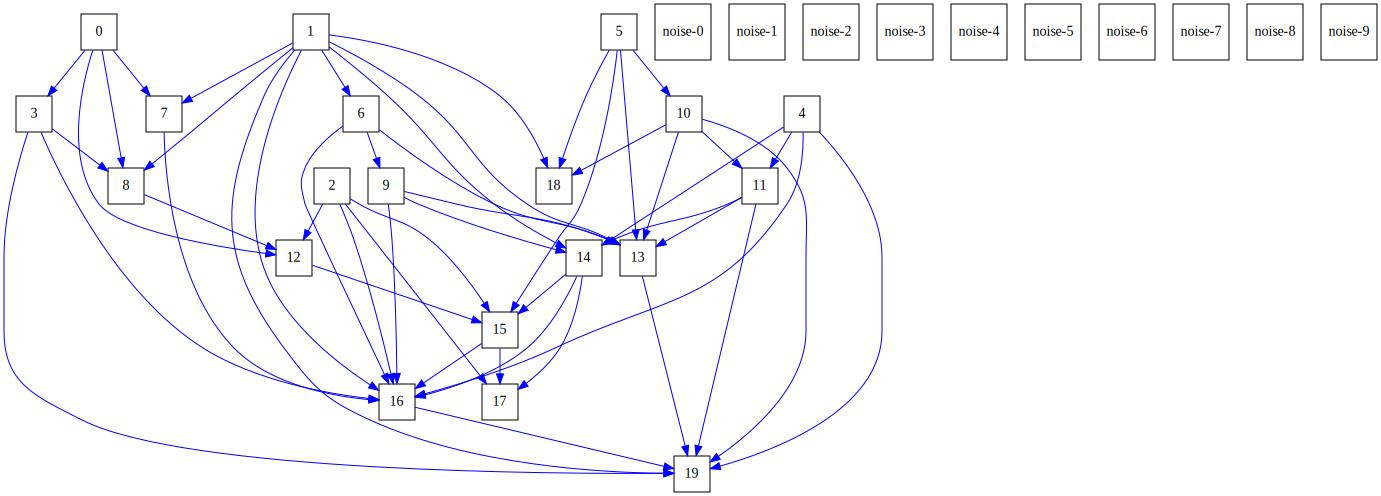

In [49]:
causal_dag.draw()

## For CD

In [44]:
display(result_df.head())

,x,y,pvalue_min,pvalue_mci,stat_min,stat_mci,pvalue_noise,stat_noise,mci_cond_ind,path_len,z_size,mci_size,mci_addition,idx
0,0,4,0.000000,0.000000,16.620379,11.647649,0.000000,16.588445,False,2,1,3,"{10, 9, 16}",0
1,0,8,0.000000,0.000000,21.146887,15.260650,0.000000,21.125513,False,2,1,4,"{6, 10, 16, 9}",0
2,0,11,0.000000,0.000007,17.924533,4.489175,0.000000,17.967505,False,3,1,5,"{9, 1, 5, 16, 10}",0
3,0,13,0.069624,0.000000,1.814352,23.647715,0.075301,1.778625,False,3,1,5,"{12, 9, 1, 16, 10}",0
4,0,15,0.144796,0.000000,1.458163,24.016343,0.157588,1.413229,False,3,2,4,"{10, 9, 16, 1}",0


(8720, 15)
(8720, 15) (8720, 15)


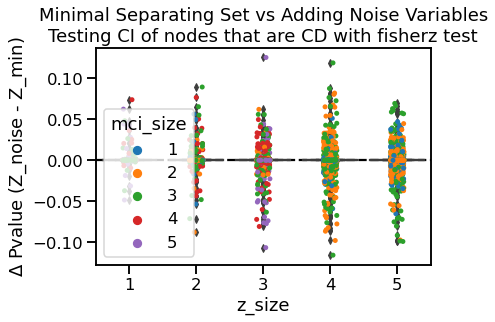

In [45]:
result_df["pvalue_diff"] = result_df["pvalue_noise"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    # x="path_len",
    hue="mci_size",
    x="z_size",
    y="pvalue_diff",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    # x="path_len",
    x="z_size",
    y="pvalue_diff",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_noise - Z_min)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Noise Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
fig.patch.set_facecolor("white")

(8720, 15)
(8720, 15) (4014, 15)


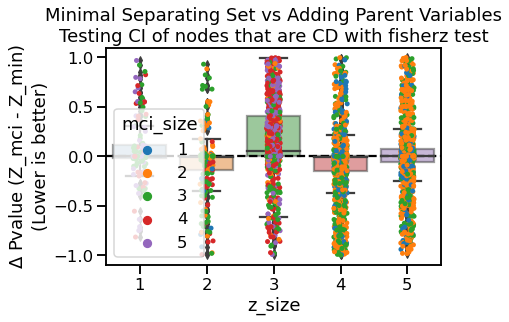

In [46]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    # x="path_len",
    y="pvalue_diff",
    x="z_size",
    hue="mci_size",
    # x="mci_size",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    # x="path_len",
    y="pvalue_diff",
    x="z_size",
    # x="mci_size",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Lower is better)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Parent Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
fig.patch.set_facecolor("white")

(1440, 19)
(1440, 19) (627, 19)


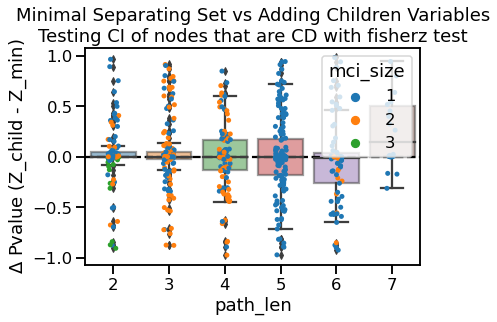

In [649]:
result_df["pvalue_diff"] = result_df["pvalue_child"] - result_df["pvalue_min"]

plot_df = result_df[result_df["child_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    x="path_len",
    # x="child_addition",
    hue="mci_size",
    # x="z_size",
    y="pvalue_diff",
    # hue="child_addition",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    x="path_len",
    # x="child_addition",
    # x="z_size",
    y="pvalue_diff",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_child - Z_min)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Children Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")

In [514]:
causal_dag.draw()

nx_dag = causal_dag.to_networkx()

fname = "/Users/adam2392/Downloads/degree_graph.gml"
nx.write_gml(nx_dag, fname)

In [515]:
fname = f"/Users/adam2392/Downloads/cd_exp_{ci_est}_degreegraph.csv"
result_df.to_csv(fname)

## For CI

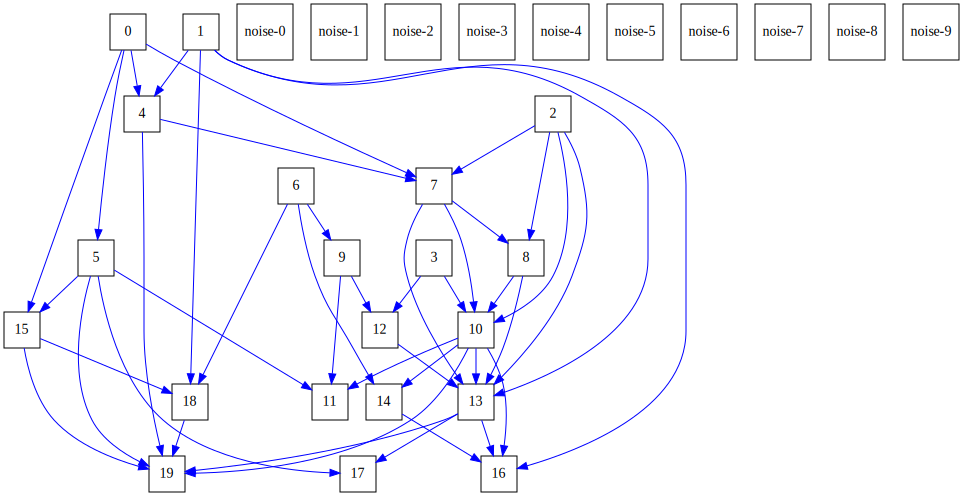

In [564]:
causal_dag.draw()

# nx_dag = causal_dag.to_networkx()

# fname = "/Users/adam2392/Downloads/degree_graph.gml"
# nx.write_gml(nx_dag, fname)

In [565]:
fname = f"/Users/adam2392/Downloads/ci_exp_{ci_est}_degreegraph_weights5-10.csv"
result_df.to_csv(fname)

(1700, 18)
(1700, 18) (1700, 18)


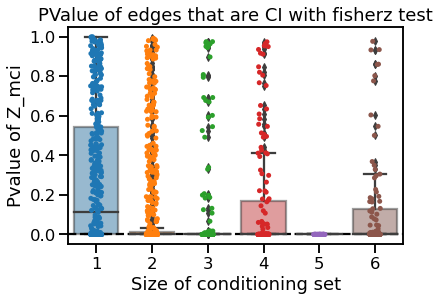

In [528]:
result_df["pvalue_diff"] = result_df["pvalue_mci"]  # - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(x="z_size", y="pvalue_diff", data=plot_df, ax=ax)
sns.boxplot(x="z_size", y="pvalue_diff", data=plot_df, ax=ax, boxprops=dict(alpha=0.5))
ax.set(
    ylabel="Pvalue of Z_mci",
    xlabel="Size of conditioning set",
    title=f"PValue of edges that are CI with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")

In [571]:
x = "path_len"
x = "z_size"
x = "mci_size"

(1700, 18)
(1700, 18) (1536, 18)


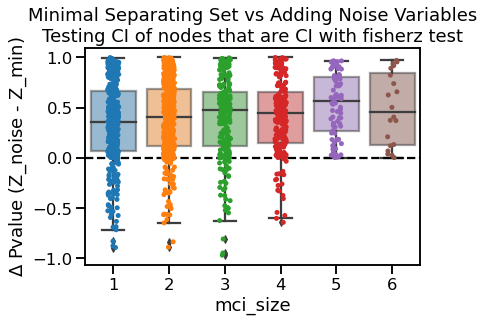

In [572]:
result_df["pvalue_diff"] = result_df["pvalue_noise"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(x=x, y="pvalue_diff", data=plot_df, ax=ax)
sns.boxplot(x=x, y="pvalue_diff", data=plot_df, ax=ax, boxprops=dict(alpha=0.5))
ax.set(
    ylabel="$\Delta$ Pvalue (Z_noise - Z_min)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Noise Variables\nTesting CI of nodes that are CI with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
fig.patch.set_facecolor("white")

(1700, 18)
(1700, 18) (484, 18)


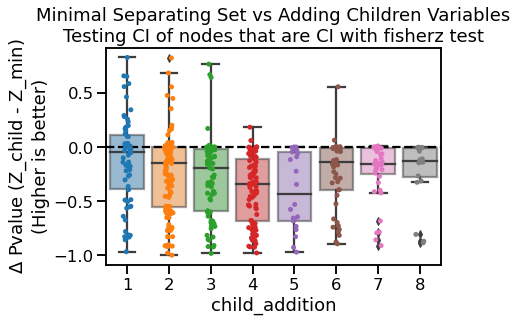

In [576]:
result_df["pvalue_diff"] = result_df["pvalue_child"] - result_df["pvalue_min"]

plot_df = result_df[result_df["child_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

x = "child_addition"
sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    # x="path_len",
    x=x,
    y="pvalue_diff",
    # hue="child_addition",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    # x="path_len",
    x=x,
    y="pvalue_diff",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_child - Z_min)\n(Higher is better)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Children Variables\nTesting CI of nodes that are CI with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")

(1700, 18)
(1700, 18) (863, 18)


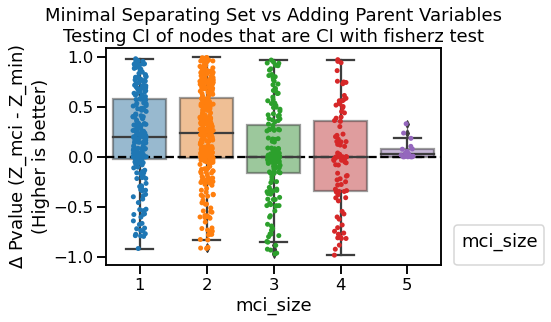

In [578]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

x = "mci_size"
sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    # x="path_len",
    y="pvalue_diff",
    x=x,
    # hue="mci_size",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    # x="path_len",
    y="pvalue_diff",
    x=x,
    # hue="mci_size",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Higher is better)",
    # xlabel="Path Length Between 2 Nodes",
    title=f"Minimal Separating Set vs Adding Parent Variables\nTesting CI of nodes that are CI with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.legend(loc=[1.04, 0], title="mci_size")
fig.patch.set_facecolor("white")

In [340]:
print(result_df["pvalue_mci"].mean())
print(result_df["pvalue_min"].mean())

0.0321344798411096
0.02261905849484673


(1640, 11)
(1640, 11) (396, 11)


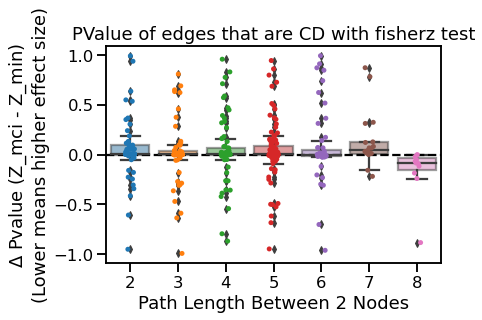

In [337]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(
    x="path_len",
    y="pvalue_diff",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
)
sns.boxplot(
    x="path_len",
    y="pvalue_diff",
    # hue="mci_size",
    data=plot_df,
    ax=ax,
    boxprops=dict(alpha=0.5),
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Lower means higher effect size)",
    xlabel="Path Length Between 2 Nodes",
    title=f"PValue of edges that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")

(1700, 18)
(1700, 18) (751, 18)


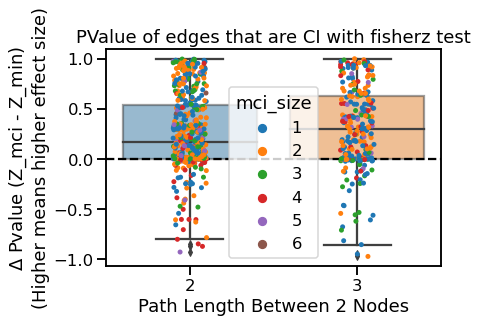

In [532]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
print(plot_df.shape)
plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(x="path_len", y="pvalue_diff", hue="mci_size", data=plot_df, ax=ax)
sns.boxplot(
    x="path_len", y="pvalue_diff", data=plot_df, ax=ax, boxprops=dict(alpha=0.5)
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Higher means higher effect size)",
    xlabel="Path Length Between 2 Nodes",
    title=f"PValue of edges that are CI with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")

(1700, 18) (1700, 18)


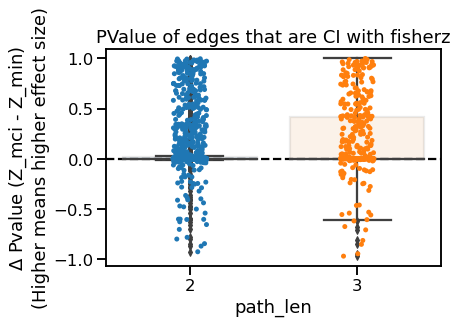

In [530]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue_min"]

plot_df = result_df[result_df["mci_addition"] != set()]
# plot_df = plot_df[plot_df["pvalue_diff"].abs() > 0.001]
print(result_df.shape, plot_df.shape)

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.stripplot(x="path_len", y="pvalue_diff", data=plot_df, ax=ax)
sns.boxplot(
    x="path_len", y="pvalue_diff", data=plot_df, ax=ax, boxprops=dict(alpha=0.1)
)
ax.set(
    ylabel="$\Delta$ Pvalue (Z_mci - Z_min)\n(Higher means higher effect size)",
    title=f"PValue of edges that are CI with {ci_est}",
)
ax.axhline([0], ls="--", color="black")

# Repeat Experiment With Conditioning on Children